### Routing

Routing enables dynamic workflow execution where the next node is determined based on state or LLM decisions. This is fundamental for building adaptive AI systems that can handle different scenarios intelligently.

**Core Concepts:**
- **Dynamic Flow:** Graph adapts to intermediate results rather than following a fixed path
- **Conditional Edges:** Use `add_conditional_edges()` to map routing decisions to specific nodes
- **Routing Functions:** Return the name of the next node to execute
- **Structured Outputs:** Leverage Pydantic models with Literal types for type-safe routing decisions

In [1]:
# Environment setup
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [2]:
# Core imports for routing workflow
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

/Users/yashsarode/Downloads/Personal Projects/Python/LangGraph-personal/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Initialize LLM
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.7)

### Example 1: Content Type Router

Route user queries to specialized content generators based on the type of content requested. This pattern is useful when you have different handlers for different formats.

In [4]:
# Define structured output schema for routing decision
class ContentRoute(BaseModel):
    """Schema for content routing decision"""
    next_step: Literal["blog", "tweet", "email"] = Field(
        description="Type of content to generate"
    )

# Create router with structured output
router_llm = llm.with_structured_output(ContentRoute)

In [5]:
# Define state schema
class ContentState(TypedDict):
    """State tracking for content generation workflow"""
    input: str
    decision: str
    output: str

In [6]:
# Router node - decides which content type to generate
def content_router(state: ContentState):
    """Analyze input and route to appropriate content generator"""
    decision = router_llm.invoke([
        SystemMessage(
            content="Classify the request as 'blog' (long-form article), "
                    "'tweet' (short social post), or 'email' (professional message)"
        ),
        HumanMessage(content=state["input"])
    ])
    return {"decision": decision.next_step}

In [7]:
# Specialized content generators
def generate_blog(state: ContentState):
    """Generate long-form blog content"""
    result = llm.invoke([
        SystemMessage(content="Write a detailed blog post (300-500 words)"),
        HumanMessage(content=state["input"])
    ])
    return {"output": result.content}

def generate_tweet(state: ContentState):
    """Generate concise tweet content"""
    result = llm.invoke([
        SystemMessage(content="Write a catchy tweet (max 280 characters)"),
        HumanMessage(content=state["input"])
    ])
    return {"output": result.content}

def generate_email(state: ContentState):
    """Generate professional email content"""
    result = llm.invoke([
        SystemMessage(content="Write a professional email with subject and body"),
        HumanMessage(content=state["input"])
    ])
    return {"output": result.content}

In [8]:
# Routing function maps decision to node name
def route_content(state: ContentState) -> str:
    """Map routing decision to actual node name"""
    routing_map = {
        "blog": "blog_generator",
        "tweet": "tweet_generator",
        "email": "email_generator"
    }
    return routing_map[state["decision"]]

In [9]:
# Build the routing workflow
content_graph = StateGraph(ContentState)

# Add all nodes
content_graph.add_node("router", content_router)
content_graph.add_node("blog_generator", generate_blog)
content_graph.add_node("tweet_generator", generate_tweet)
content_graph.add_node("email_generator", generate_email)

# Define flow: START -> router -> conditional routing -> END
content_graph.add_edge(START, "router")
content_graph.add_conditional_edges(
    "router",
    route_content,
    {
        "blog_generator": "blog_generator",
        "tweet_generator": "tweet_generator",
        "email_generator": "email_generator"
    }
)

# All generators flow to END
content_graph.add_edge("blog_generator", END)
content_graph.add_edge("tweet_generator", END)
content_graph.add_edge("email_generator", END)

# Compile the graph
content_workflow = content_graph.compile()

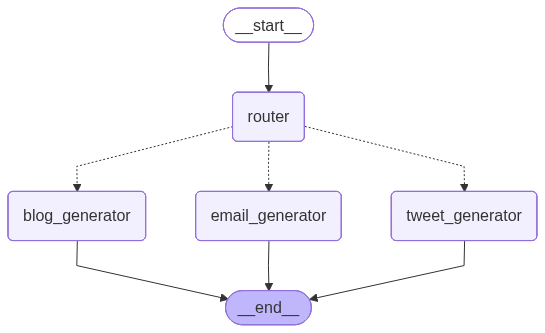

In [10]:
# Visualize the routing workflow
display(Image(content_workflow.get_graph().draw_mermaid_png()))

In [11]:
# Test the content router
result = content_workflow.invoke({
    "input": "Write something about AI ethics in healthcare"
})

print(f"Routed to: {result['decision']}")
print(f"\nGenerated content:\n{result['output']}")

Routed to: blog

Generated content:
**The Crucial Role of AI Ethics in Healthcare: Ensuring Fairness, Transparency, and Patient Trust**

The integration of Artificial Intelligence (AI) in healthcare has revolutionized the way medical professionals diagnose, treat, and manage patient care. AI-powered algorithms can analyze vast amounts of medical data, identify patterns, and provide insights that can lead to better patient outcomes. However, as AI becomes increasingly pervasive in healthcare, concerns about AI ethics have grown. Ensuring that AI systems are fair, transparent, and prioritize patient well-being is essential to maintaining trust and promoting effective healthcare delivery.

**Key Ethical Concerns in AI-Driven Healthcare**

1. **Bias and Discrimination**: AI algorithms can perpetuate existing biases and disparities in healthcare if they are trained on biased data. This can lead to unequal treatment and outcomes for certain patient groups, such as racial or ethnic minorities

## Example 2: Question Classification Router

Route questions to different processing pipelines based on complexity. Simple questions get quick responses, while complex ones trigger deeper analysis.

In [12]:
# Routing schema for question complexity
class QuestionRoute(BaseModel):
    """Classification of question complexity"""
    complexity: Literal["simple", "complex", "research"] = Field(
        description="Complexity level of the question"
    )
    
question_router = llm.with_structured_output(QuestionRoute)

In [13]:
# State for question processing
class QuestionState(TypedDict):
    question: str
    complexity: str
    answer: str

In [14]:
# Classify question complexity
def classify_question(state: QuestionState):
    """Determine if question needs simple answer, detailed explanation, or research"""
    classification = question_router.invoke([
        SystemMessage(
            content="Classify as 'simple' (factual, quick answer), "
                    "'complex' (needs explanation), or 'research' (requires deep analysis)"
        ),
        HumanMessage(content=state["question"])
    ])
    return {"complexity": classification.complexity}

In [15]:
# Different processing nodes based on complexity
def handle_simple(state: QuestionState):
    """Quick factual response"""
    result = llm.invoke([
        SystemMessage(content="Provide a concise, factual answer (1-2 sentences)"),
        HumanMessage(content=state["question"])
    ])
    return {"answer": result.content}

def handle_complex(state: QuestionState):
    """Detailed explanation with examples"""
    result = llm.invoke([
        SystemMessage(content="Provide a detailed explanation with examples"),
        HumanMessage(content=state["question"])
    ])
    return {"answer": result.content}

def handle_research(state: QuestionState):
    """In-depth analysis with multiple perspectives"""
    result = llm.invoke([
        SystemMessage(
            content="Provide comprehensive analysis covering multiple angles, "
                    "recent developments, and implications"
        ),
        HumanMessage(content=state["question"])
    ])
    return {"answer": result.content}

In [16]:
# Routing logic for question complexity
def route_by_complexity(state: QuestionState) -> str:
    """Route to appropriate handler based on complexity"""
    return state["complexity"]  # Node names match complexity values

In [17]:
# Build question routing graph
question_graph = StateGraph(QuestionState)

# Add nodes
question_graph.add_node("classifier", classify_question)
question_graph.add_node("simple", handle_simple)
question_graph.add_node("complex", handle_complex)
question_graph.add_node("research", handle_research)

# Define edges
question_graph.add_edge(START, "classifier")
question_graph.add_conditional_edges(
    "classifier",
    route_by_complexity,
    {"simple": "simple", "complex": "complex", "research": "research"}
)

# All handlers end the workflow
for node in ["simple", "complex", "research"]:
    question_graph.add_edge(node, END)

question_workflow = question_graph.compile()

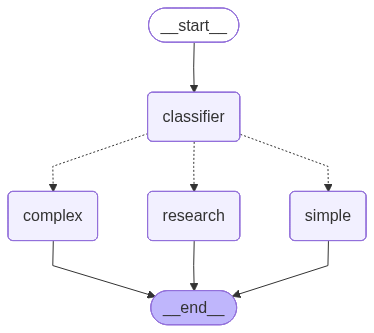

In [18]:
# Visualize question routing
display(Image(question_workflow.get_graph().draw_mermaid_png()))

In [19]:
# Test with different question types
questions = [
    "What is Python?",
    "Explain how transformers work in NLP",
    "What are the implications of AGI on society?"
]

for q in questions:
    result = question_workflow.invoke({"question": q})
    print(f"Question: {q}")
    print(f"Complexity: {result['complexity']}")
    print(f"Answer: {result['answer'][:200]}...\n")

Question: What is Python?
Complexity: simple
Answer: Python is a high-level, interpreted programming language known for its simplicity, readability, and versatility, widely used for web development, data analysis, artificial intelligence, and more. It w...

Question: Explain how transformers work in NLP
Complexity: complex
Answer: Transformers are a type of neural network architecture that have revolutionized the field of Natural Language Processing (NLP). They were introduced in the paper "Attention is All You Need" by Vaswani...

Question: What are the implications of AGI on society?
Complexity: research
Answer: The implications of Artificial General Intelligence (AGI) on society are far-reaching and multifaceted. AGI, which refers to a hypothetical AI system that possesses human-like intelligence and capabil...



### Key Patterns for Production

**Routing Best Practices:**

1. **Type Safety:** Use Pydantic with Literal types to ensure valid routing decisions
2. **Clear Mapping:** Routing function return values must match actual node names
3. **Specialized Nodes:** Keep each handler focused on one task for maintainability
4. **Fallback Logic:** Consider adding default routing for edge cases
5. **Monitoring:** Log routing decisions to analyze patterns and improve accuracy

**When to Use Routing:**
- Multiple content formats or response styles
- Different processing pipelines based on input characteristics
- Complexity-based resource allocation
- Domain-specific expert systems
- Multi-step workflows with branching logic

## Performance Considerations

**Router LLM Selection:**
- Use lightweight models for routing decisions to reduce latency
- Reserve powerful models for actual content generation
- Consider caching routing decisions for similar inputs

**Cost Optimization:**
- Router calls are typically cheaper than full generation
- Reduces wasted tokens on wrong content type
- Enables targeted use of expensive models only where needed